In [4]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
login_df= pd.read_json('/logins.json')

In [6]:
login_df.describe()

,login_time
count,93142
unique,92265
top,1970-02-12 11:16:53
freq,3
first,1970-01-01 20:12:16
last,1970-04-13 18:57:38


In [7]:
login_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
login_time    93142 non-null datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [8]:
login_df.head(2)

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10


# EDA
Aggregate these login counts based on 15minute
time intervals, and
visualize and describe the resulting time series of login counts in ways that best characterize the
underlying patterns of the demand. Please report/illustrate important features of the demand,
such as daily cycles. If there are data quality issues, please report them.

In [9]:
# I need to count the number of logins in 15 minute intervals

 I want to iterate over the existing login_df and identify which time stamp the login belongs in. (i.e. is greater then but less then the next)
 and add to count column of counter_df for that row.

In [10]:
rng = pd.date_range('1970-01-01 20:00:00', '1970-04-13 19:00:00', freq='15T')
ts = pd.Series(np.zeros(len(rng)), index=rng)

In [11]:
login_df = login_df.sort_values('login_time') # the login times were not in order, so this gets them aright.
login_df = login_df.reset_index(drop=True)
login_df.head()

,login_time
0,1970-01-01 20:12:16
1,1970-01-01 20:13:18
2,1970-01-01 20:16:10
3,1970-01-01 20:16:36
4,1970-01-01 20:16:37


In [12]:
p = 0 
for i in range(len(login_df)):
    s = ts.index[p] #start time
    e = ts.index[p+1] #end time
    t = login_df['login_time'][i]
    if s < t < e:
        ts[p] = ts[p] + 1
    else:
        while (e < t): #increment to the next time 
            p = p + 1 
            s = ts.index[p] #change start time
            e = ts.index[p+1] # change end time
        ts[p] = ts[p] + 1

In [13]:
ts.head(3)

1970-01-01 20:00:00    2.0
1970-01-01 20:15:00    6.0
1970-01-01 20:30:00    9.0
Freq: 15T, dtype: float64

In [14]:
counter_df= pd.DataFrame(ts)
counter_df= counter_df.reset_index()
counter_df.columns= ['time_stamp', 'count']
counter_df.head(5)

,time_stamp,count
0,1970-01-01 20:00:00,2.0
1,1970-01-01 20:15:00,6.0
2,1970-01-01 20:30:00,9.0
3,1970-01-01 20:45:00,7.0
4,1970-01-01 21:00:00,1.0


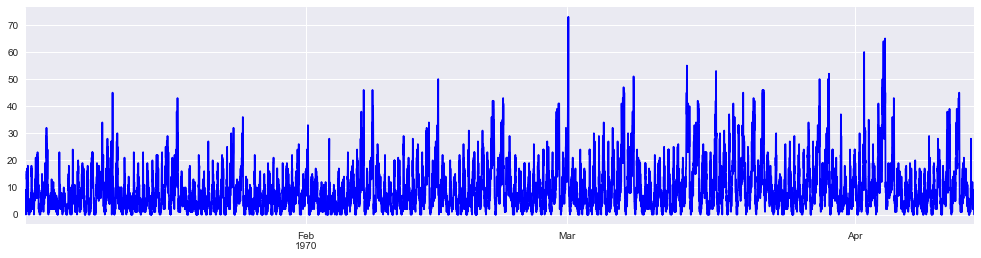

In [15]:
plt.figure(figsize=(17,4))
ts.plot(color='blue')
plt.show()

There does seem to be a semi-consistent pattern over log-ins although a few noticible peaks. Specifically in March and April

The observable pattern is spikes at regular intervals, I need to look closer at a shorter time frame to better predict. At this level the pattern of spikes is ahrd to define (daily or bidaily?)

In [18]:
first_week = ts[:700]
first_week.tail(10)

1970-01-09 00:30:00    20.0
1970-01-09 00:45:00    10.0
1970-01-09 01:00:00    17.0
1970-01-09 01:15:00    23.0
1970-01-09 01:30:00    18.0
1970-01-09 01:45:00    18.0
1970-01-09 02:00:00    10.0
1970-01-09 02:15:00    20.0
1970-01-09 02:30:00    13.0
1970-01-09 02:45:00    12.0
Freq: 15T, dtype: float64

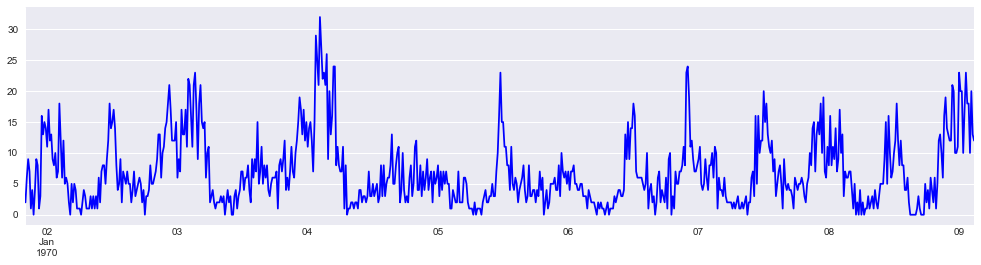

In [36]:
plt.figure(figsize=(17,4))
first_week.plot(color='blue')
plt.show()

From the weekly breakdown it is easier to see that there is an upturn of log-ins in the early hours of each day (the largest spike example on Jan-04) and another about halfway through the day (a large example between Jan 05 mid-day)

In [30]:
counter_df['weekday'] = counter_df['time_stamp'].dt.dayofweek

counter_df= counter_df.sort_values('weekday')
counter_df.head(3)

,time_stamp,count,weekday
9788,1970-04-13 19:00:00,0.0,0
2379,1970-01-26 14:45:00,4.0,0
2387,1970-01-26 16:45:00,10.0,0


In [34]:
counter_df['weekday']= counter_df['weekday'].replace(0, 'Mon')
counter_df['weekday']= counter_df['weekday'].replace(1, 'Tue')
counter_df['weekday']= counter_df['weekday'].replace(2, 'Wed')
counter_df['weekday']= counter_df['weekday'].replace(3, 'Thu')
counter_df['weekday']= counter_df['weekday'].replace(4, 'Fri')
counter_df['weekday']= counter_df['weekday'].replace(5, 'Sat')
counter_df['weekday']= counter_df['weekday'].replace(6, 'Sun')
counter_df.head(3)

,time_stamp,count,weekday
9788,1970-04-13 19:00:00,0.0,Mon
2379,1970-01-26 14:45:00,4.0,Mon
2387,1970-01-26 16:45:00,10.0,Mon


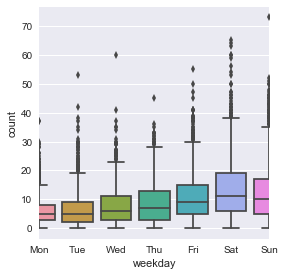

In [41]:

sns.factorplot(x= 'weekday', y= 'count', data= counter_df, kind= 'box')
plt.xlim(xmin= 0, xmax= 6)
plt.show()

In [16]:
# what is the highest peak of all?
ts.max()

73.0

# Cumulative Analysis
Logins increase throughout the week, with the most frequently happening on Saturday and Sunday, although there are outliers on Tuesday and Wednesday that almost match the highest data points. The greatest  peak (the 73 listed above) is on a Sunday.

Logins generally also match ~ 12 hour pattern, logins usually happening in the morning and after work hours (early evening). Lowest overall log-ins are during work hours, and on work days. Demand appears to match off-time for a 9-5 employee. 